In [1]:
import blocksci

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import collections
import random

In [4]:
import utils

In [5]:
import analysis

In [6]:
import gc

In [7]:
import joblib

In [8]:
from utils import grouper

In [9]:
chain = blocksci.Blockchain(utils.blocksci_config())

In [10]:
my_cm = blocksci.cluster.ClusterManager(utils.latest_clustering(), chain)

In [11]:
stored_txes = blocksci.GroundTruth(utils.remaining_txes(), chain)

In [12]:
datestring = "20210803"

In [13]:
datestring_new = "20210804"

In [14]:
positive_threshold = .99
positive_threshold_nofp = .9977
negative_threshold = .01

In [15]:
def get_y_predict():
    return np.load("/home/ubuntu/Data/full-prediction/{}-full-predict.npy".format(datestring))

In [16]:
def get_all_spent_mask(rerun=False):
    if rerun:
        all_spent_mask_txes = stored_txes.transactions().map(lambda tx: tx.outputs.all(lambda o: o.is_spent))
        all_spent_mask = np.array([x for x in all_spent_mask_txes for _ in (0, 1)])
        np.save("/home/ubuntu/Data/full-prediction/{}-all-spent-mask.npy".format(datestring), all_spent_mask)
        return all_spent_mask
    return np.load("/home/ubuntu/Data/full-prediction/{}-all-spent-mask.npy".format(datestring))

def get_all_spent_mask_txes(rerun=False):
    if rerun:
        all_spent_mask_txes = stored_txes.transactions().map(lambda tx: tx.outputs.all(lambda o: o.is_spent))
        np.save("/home/ubuntu/Data/full-prediction/{}-all-spent-mask_txes.npy".format(datestring), all_spent_mask_txes)
        return all_spent_mask_txes
    return np.load("/home/ubuntu/Data/full-prediction/{}-all-spent-mask_txes.npy".format(datestring))

In [17]:
# load mask of which transactions should have receive predictions
mask_should_predict = np.load("/home/ubuntu/Data/full-prediction/{}-mask-predict.npy".format(datestring))

In [18]:
np.sum(mask_should_predict), len(mask_should_predict)

(598218668, 619306108)

### Load prediction results

In [19]:
y_predict = get_y_predict()

In [20]:
len(y_predict)

619306108

In [21]:
np.sum(y_predict == 0.0)

63528863

In [22]:
np.sum(y_predict < 0.01)

158100798

In [23]:
np.sum(y_predict == 1.0)

64065903

In [24]:
np.sum(y_predict > 0.99)

158359053

In [25]:
np.sum(y_predict == 0.99)

35514

In [26]:
# all_spent_mask = get_all_spent_mask(True)
all_spent_mask = get_all_spent_mask()
len(all_spent_mask)

619306108

In [27]:
# all_spent_mask_txes = get_all_spent_mask_txes(True)
all_spent_mask_txes = get_all_spent_mask_txes()
len(all_spent_mask_txes)

309653054

In [28]:
assert len(all_spent_mask) == len(y_predict)

In [29]:
len(y_predict[~all_spent_mask]) // 2

19294986

In [30]:
np.sum(y_predict[~all_spent_mask] > positive_threshold)

8714322

In [31]:
np.sum(y_predict[~all_spent_mask] > positive_threshold_nofp)

5917822

In [32]:
np.sum(y_predict[~all_spent_mask & mask_should_predict] > positive_threshold) - np.sum(y_predict[~all_spent_mask & mask_should_predict] > positive_threshold_nofp)

2796195

In [33]:
np.sum(y_predict[~all_spent_mask] > positive_threshold_nofp) + np.sum(y_predict[all_spent_mask] > positive_threshold), np.sum(y_predict > positive_threshold)

(155562553, 158359053)

In [34]:
155562553 / (len(y_predict) // 2)

0.5023769376419585

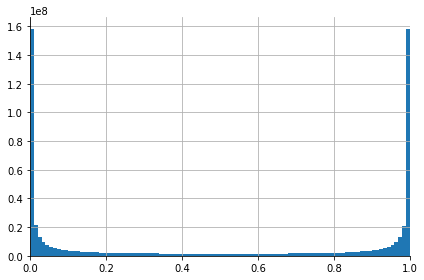

In [35]:
ax = pd.Series(y_predict).hist(bins=100)
ax.set_xlim(0, 1)
sns.despine()
plt.tight_layout()
plt.savefig("figures/random-forest-predictions.pdf")

### Get cluster IDs that would be merged

In [42]:
cluster_id = blocksci.heuristics.cluster_id(my_cm)
output_cluster_id = blocksci.heuristics.output_cluster_id(my_cm)

In [43]:
rerun_ = False
if rerun_:
    tx_cluster_ids = stored_txes.transactions().map(lambda tx: cluster_id(tx))
    output_cluster_ids = stored_txes.transactions().outputs.map(lambda o: output_cluster_id(o))
    cluster_tx_count = np.array([cluster.tx_count for cluster in my_cm.clusters()])
    np.save("/home/ubuntu/Data/full-prediction/{}-tx-cluster-ids.npy".format(datestring_new), tx_cluster_ids)
    np.save("/home/ubuntu/Data/full-prediction/{}-output-cluster-ids.npy".format(datestring_new), output_cluster_ids)
    np.save("/home/ubuntu/Data/full-prediction/{}-cluster-tx-count.npy".format(datestring_new), cluster_tx_count)
else:
    tx_cluster_ids = np.load("/home/ubuntu/Data/full-prediction/{}-tx-cluster-ids.npy".format(datestring_new))
    output_cluster_ids = np.load("/home/ubuntu/Data/full-prediction/{}-output-cluster-ids.npy".format(datestring_new))
    cluster_tx_count = np.load("/home/ubuntu/Data/full-prediction/{}-cluster-tx-count.npy".format(datestring_new))

In [44]:
assert len(output_cluster_ids) == len(y_predict)
assert len(output_cluster_ids) // 2 == len(tx_cluster_ids)

In [46]:
for x, y in grouper(mask_should_predict, 2):
    assert x == y
del x, y

In [49]:
clusters_to_merge = []
clusters_to_not_merge = []
for tx_cluster, (out_0_id, out_1_id), (out_0_prob, out_1_prob), (should_merge, _), all_outs_spent in zip(tx_cluster_ids, grouper(output_cluster_ids, 2), grouper(y_predict, 2), grouper(mask_should_predict, 2), all_spent_mask_txes):
    
    # skip coinbase
    if tx_cluster == 4294967295:
        continue
    if not should_merge:
        continue
    
    pos_thres = positive_threshold
    if not all_outs_spent:
        pos_thres = positive_threshold_nofp
    
    if out_0_prob > pos_thres:
        clusters_to_merge.append((min(tx_cluster, out_0_id), max(tx_cluster, out_0_id)))
    elif out_0_prob < negative_threshold:
        clusters_to_not_merge.append((min(tx_cluster, out_0_id), max(tx_cluster, out_0_id)))
    
    if out_1_prob > pos_thres:
        clusters_to_merge.append((min(tx_cluster, out_1_id), max(tx_cluster, out_1_id)))
    elif out_1_prob < negative_threshold:
        clusters_to_not_merge.append((min(tx_cluster, out_1_id), max(tx_cluster, out_1_id)))

In [50]:
# (121058446, 119896698)
len(clusters_to_merge), len(clusters_to_not_merge)

(155513552, 158045991)

In [52]:
np.save("/home/ubuntu/Data/full-prediction/{}-clusters-to-merge.npy".format(datestring_new), np.array(clusters_to_merge))

In [53]:
np.save("/home/ubuntu/Data/full-prediction/{}-clusters-to-not-merge.npy".format(datestring_new), np.array(clusters_to_not_merge))

### Restart notebook, reload data 

In [36]:
clusters_to_merge = np.load("/home/ubuntu/Data/full-prediction/{}-clusters-to-merge.npy".format(datestring_new))

In [37]:
dumb_clusters_to_merge = blocksci.heuristics.refine_clustering(my_cm, clusters_to_merge, [], 2**31)

155513552 cluster pairs to merge, 0 cluster pairs to ignore
Finding largest cluster ID in clustersToMerge
Initializing union find structures for 658158218 items.
Initialized Union-Find with 184302672 unique clusters
Added constraints to 0 clusters
100.00% done
Percentiles of size of smaller cluster:
1 is the 90 percentile
6 is the 99 percentile
25 is the 99.9 percentile
114 is the 99.99 percentile
1696 is the 99.999 percentile

39801817 clusters after merging
11012697 merges skipped because parents were already merged
0 merges skipped because parents were larger than the threshold of 2147483648
0 merges skipped because of constraint violations



In [38]:
np.save("/home/ubuntu/Data/full-prediction/{}-dumb-clusters-to-merge.npy".format(datestring_new), dumb_clusters_to_merge)

In [37]:
clusters_to_not_merge = np.load("/home/ubuntu/Data/full-prediction/{}-clusters-to-not-merge.npy".format(datestring_new))

In [38]:
refined_clusters_to_merge = blocksci.heuristics.refine_clustering(my_cm, clusters_to_merge, clusters_to_not_merge, 2**31)

155513552 cluster pairs to merge, 158045991 cluster pairs to ignore
Finding largest cluster ID in clustersToMerge
Initializing union find structures for 658158218 items.
Initialized Union-Find with 184302672 unique clusters
Added constraints to 28840601 clusters
100.00% done
Percentiles of size of smaller cluster:
1 is the 90 percentile
6 is the 99 percentile
25 is the 99.9 percentile
102 is the 99.99 percentile
578 is the 99.999 percentile

40033157 clusters after merging
10830429 merges skipped because parents were already merged
0 merges skipped because parents were larger than the threshold of 2147483648
413608 merges skipped because of constraint violations



In [40]:
np.save("/home/ubuntu/Data/full-prediction/{}-refined-clusters-to-merge.npy".format(datestring_new), refined_clusters_to_merge)

### Create a basic refined clustering, without constraints

In [41]:
y_predict = get_y_predict()

In [42]:
%time coinbase_idx = set(stored_txes.transactions().where(lambda tx: tx.is_coinbase).index)

CPU times: user 29.3 s, sys: 29.4 s, total: 58.7 s
Wall time: 5min 44s


In [43]:
len(coinbase_idx)

0

In [44]:
tx_cluster_ids = np.load("/home/ubuntu/Data/full-prediction/{}-tx-cluster-ids.npy".format(datestring_new))
output_cluster_ids = np.load("/home/ubuntu/Data/full-prediction/{}-output-cluster-ids.npy".format(datestring_new))

In [45]:
assert stored_txes.transactions().size == len(y_predict) // 2
assert len(tx_cluster_ids) == len(y_predict) // 2
assert len(y_predict) == len(output_cluster_ids)

In [46]:
txes_to_merge = []

for tx_index, (out_0_prob, out_1_prob), tx_cluster, (ocid_0, ocid_1), (should_merge, _), all_outs_spent in zip(
    stored_txes.transactions().index,
    grouper(y_predict, 2),
    tx_cluster_ids,
    grouper(output_cluster_ids, 2),
    grouper(mask_should_predict, 2),
    all_spent_mask_txes
):
    
    if not should_merge:
        continue
    
    if tx_index in coinbase_idx:
        continue
        
    pos_thres = positive_threshold
    if not all_outs_spent:
        pos_thres = positive_threshold_nofp

    if out_0_prob > pos_thres and out_1_prob > pos_thres:
        continue
    if out_0_prob > pos_thres:
        txes_to_merge.append((tx_index, 0))
    elif out_1_prob  > pos_thres:
        txes_to_merge.append((tx_index, 1))

In [47]:
len(txes_to_merge)

155513552

In [48]:
len(txes_to_merge) / stored_txes.transactions().size

0.5022186927954536

In [49]:
np.save("/home/ubuntu/Data/full-prediction/{}-unrefined-txes-to-cluster.npy".format(datestring_new), txes_to_merge)

In [50]:
del y_predict, tx_cluster_ids, output_cluster_ids, mask_should_predict, all_spent_mask_txes

In [51]:
gc.collect()

0

In [52]:
refined_clustering_dumb = blocksci.cluster.ClusterManager.refine_clustering("/home/ubuntu/Data/clusters/{}-refined-dumb".format(datestring_new), utils.latest_clustering(), txes_to_merge, chain)

Refining clustering at path /home/ubuntu/Data/clusters/20210715-base-clustering.
100.00% done
Successfully stored cluster data at /home/ubuntu/Data/clusters/20210804-refined-dumb
Serializing cluster tx counts.
Flattening cluster tx vector.
Tx counts match.
Serializing transaction IDs.
Computing transaction offsets.
Serializing cluster tx offsets.


In [53]:
del txes_to_merge

### Create a smarter refined clustering, with constraints

In [19]:
y_predict = get_y_predict()

In [20]:
%time coinbase_idx = set(stored_txes.transactions().where(lambda tx: tx.is_coinbase).index)

CPU times: user 26.4 s, sys: 21.9 s, total: 48.3 s
Wall time: 3min 40s


In [21]:
tx_cluster_ids = np.load("/home/ubuntu/Data/full-prediction/{}-tx-cluster-ids.npy".format(datestring_new))
output_cluster_ids = np.load("/home/ubuntu/Data/full-prediction/{}-output-cluster-ids.npy".format(datestring_new))

In [22]:
assert stored_txes.transactions().size == len(y_predict) // 2
assert len(tx_cluster_ids) == len(y_predict) // 2
assert len(y_predict) == len(output_cluster_ids)

In [23]:
refined_clusters_to_merge = np.load("/home/ubuntu/Data/full-prediction/{}-refined-clusters-to-merge.npy".format(datestring_new))

In [24]:
valid_merges = set([tuple(x) for x in refined_clusters_to_merge])

In [25]:
all_spent_mask_txes = get_all_spent_mask_txes()

In [26]:
del refined_clusters_to_merge

In [27]:
txes_to_merge = []

for tx_index, (out_0_prob, out_1_prob), tx_cluster, (ocid_0, ocid_1), (should_merge, _), all_outs_spent in zip(
    stored_txes.transactions().index,
    grouper(y_predict, 2),
    tx_cluster_ids,
    grouper(output_cluster_ids, 2),
    grouper(mask_should_predict, 2),
    all_spent_mask_txes
):
    
    if not should_merge:
        continue

    if tx_index in coinbase_idx:
        continue
    
    pos_thres = positive_threshold
    if not all_outs_spent:
        pos_thres = positive_threshold_nofp

    if out_0_prob > pos_thres and out_1_prob > pos_thres:
        continue
    if out_0_prob > pos_thres:
        ctuple = (min(tx_cluster, ocid_0), max(tx_cluster, ocid_0))
        if ctuple in valid_merges:
            txes_to_merge.append((tx_index, 0))
    elif out_1_prob > pos_thres:
        ctuple = (min(tx_cluster, ocid_1), max(tx_cluster, ocid_1))
        if ctuple in valid_merges:
            txes_to_merge.append((tx_index, 1))

In [28]:
len(txes_to_merge)

150865528

In [29]:
del y_predict, tx_cluster_ids, output_cluster_ids

In [30]:
gc.collect()

0

In [31]:
np.save("/home/ubuntu/Data/full-prediction/{}-refined-txes-to-cluster.npy".format(datestring_new), txes_to_merge)

In [19]:
txes_to_merge = np.load("/home/ubuntu/Data/full-prediction/{}-refined-txes-to-cluster.npy".format(datestring_new))

In [20]:
refined_clustering = blocksci.cluster.ClusterManager.refine_clustering("/home/ubuntu/Data/clusters/{}-refined-smart".format(datestring_new), utils.latest_clustering(), txes_to_merge, chain)

Refining clustering at path /home/ubuntu/Data/clusters/20210715-base-clustering.
100.00% done
Successfully stored cluster data at /home/ubuntu/Data/clusters/20210804-refined-smart
Serializing cluster tx counts.
Flattening cluster tx vector.
Tx counts match.
Serializing transaction IDs.
Computing transaction offsets.
Serializing cluster tx offsets.


In [21]:
del txes_to_merge

## Cluster Collapse

In [19]:
my_cm.clusters().size

658522992

In [20]:
refined_clustering_dumb = blocksci.cluster.ClusterManager("/home/ubuntu/Data/clusters/{}-refined-dumb".format(datestring_new), chain)

In [21]:
refined_clustering_dumb.clusters().size

514022137

In [22]:
refined_clustering_smart = blocksci.cluster.ClusterManager("/home/ubuntu/Data/clusters/{}-refined-smart".format(datestring_new), chain)

In [23]:
refined_clustering_smart.clusters().size

514253477

In [24]:
refined_clustering_smart.clusters().size - refined_clustering_dumb.clusters().size

231340

### Check for Mt. Gox cluster collapse

In [25]:
mtgox_address = chain.address_from_string("1LNWw6yCxkUmkhArb2Nf2MPw6vG7u5WG7q")

In [26]:
mt_gox_before = my_cm.clusters()[my_cm.cluster_with_address(mtgox_address).index]

In [27]:
mt_gox_before.tx_count, mt_gox_before.type_equiv_size, len(mt_gox_before)

(4161568, 13214890, 13201430)

In [28]:
mt_gox_before.index

221

In [29]:
mt_gox_dumb = refined_clustering_dumb.clusters()[refined_clustering_dumb.cluster_with_address(mtgox_address).index]

In [30]:
mt_gox_dumb.index

213

In [31]:
mt_gox_dumb.tx_count, mt_gox_dumb.type_equiv_size, len(mt_gox_dumb)

(108196018, 357583427, 223928805)

In [32]:
mt_gox_smart = refined_clustering_smart.clusters()[refined_clustering_smart.cluster_with_address(mtgox_address).index]

In [33]:
mt_gox_smart.index

221

In [34]:
mt_gox_smart.tx_count, mt_gox_smart.type_equiv_size, len(mt_gox_smart)

(4397689, 14850404, 14511165)

### Check for large cluster (over 10 million type equiv addresses)

In [35]:
largest_cluster_before = my_cm.clusters().where(lambda x: x.type_equiv_size > 10000000).to_list()

In [36]:
largest_cluster_dumb = refined_clustering_dumb.clusters().where(lambda x: x.type_equiv_size > 10000000).to_list()

In [37]:
largest_cluster_smart = refined_clustering_smart.clusters().where(lambda x: x.type_equiv_size > 10000000).to_list()

In [38]:
for cluster in largest_cluster_before:
    print(cluster.index, cluster.type_equiv_size, cluster.tx_count)
del cluster

221 13214890 4161568
34508 34534228 8851845


In [39]:
for cluster in largest_cluster_dumb:
    print(cluster.index, cluster.type_equiv_size, cluster.tx_count)
del cluster

213 357583427 108196018


In [40]:
for cluster in largest_cluster_smart:
    print(cluster.index, cluster.type_equiv_size, cluster.tx_count)
del cluster

221 14850404 4397689
29860 50353021 20379073
4672178 10902955 1084997
4856524 10820964 834042
7661318 10459989 1083996


### Check for cluster collapse

In [17]:
import yaml

In [18]:
with open('walletexplorer.yaml') as f:
    cluster_tags = yaml.safe_load(f)

In [19]:
cluster_tags = cluster_tags['tags']

In [44]:
more_clusters = {}
for entry in cluster_tags:
    more_clusters[entry['label']] = entry['address']

In [45]:
new_clusters_dumb_full = collections.defaultdict(list)
new_clusters_smart_full = collections.defaultdict(list)

for cluster_name, cluster_address in more_clusters.items():
    address = chain.address_from_string(cluster_address)
    
    dumb_cluster = refined_clustering_dumb.cluster_with_address(address)
    new_clusters_dumb_full[dumb_cluster.index].append(cluster_name)
    
    smart_cluster = refined_clustering_smart.cluster_with_address(address)
    new_clusters_smart_full[smart_cluster.index].append(cluster_name)

In [46]:
len(more_clusters), len(new_clusters_dumb_full), len(new_clusters_smart_full)

(273, 161, 266)

In [47]:
len(new_clusters_dumb_full[213])

113

In [ ]:
new_clusters_dumb_full

In [ ]:
new_clusters_smart_full

In [50]:
cluster_count = 0
for key in new_clusters_smart_full:
    if len(new_clusters_smart_full[key]) > 1:
        print(cluster_count, new_clusters_smart_full[key])
        cluster_count += 1

0 ['localbitcoins.com', 'bitcoin.de']
1 ['poloniex', 'yabtcl.com']
2 ['agoramarket', 'germanplazamarket']
3 ['betcoin.tm', 'luckyb.it']
4 ['xapo', 'coinhako.com']
5 ['clevercoin.com', 'bitbay.net']
6 ['cointrader.net', 'anxpro.com']


### Extract how new clusters are formed

In [51]:
clusters_to_merge = np.load("/home/ubuntu/Data/full-prediction/{}-clusters-to-merge.npy".format(datestring_new))

In [52]:
dumb_families = blocksci.heuristics.get_clustered_families(my_cm, clusters_to_merge, [], 2**31)

155513552 cluster pairs to merge, 0 cluster pairs to ignore
Finding largest cluster ID in clustersToMerge
Initializing union find structures for 658158218 items.
Initialized Union-Find with 184302672 unique clusters
Added constraints to 0 clusters
100.00% done


In [53]:
len(dumb_families)

39801817

In [54]:
np.save("/home/ubuntu/Data/full-prediction/{}-dumb-families.npy".format(datestring_new), dumb_families)

/home/ubuntu/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [55]:
clusters_to_not_merge = np.load("/home/ubuntu/Data/full-prediction/{}-clusters-to-not-merge.npy".format(datestring_new))

In [56]:
smart_families = blocksci.heuristics.get_clustered_families(my_cm, clusters_to_merge, clusters_to_not_merge, 2**31)

155513552 cluster pairs to merge, 158045991 cluster pairs to ignore
Finding largest cluster ID in clustersToMerge
Initializing union find structures for 658158218 items.
Initialized Union-Find with 184302672 unique clusters
Added constraints to 28840601 clusters
100.00% done


In [57]:
len(smart_families)

40033157

In [58]:
np.save("/home/ubuntu/Data/full-prediction/{}-smart-families.npy".format(datestring_new), smart_families)

#### Reload notebook and data

In [19]:
dumb_families = np.load("/home/ubuntu/Data/full-prediction/{}-dumb-families.npy".format(datestring_new), allow_pickle=True)

In [20]:
dumb_address_start = []
dumb_address_increase = []
dumb_tx_start = []
dumb_tx_increase = []
for family in dumb_families:
    tx_counts = []
    address_counts = []
    for cid in family:
        before_cluster = my_cm.clusters()[cid]
        tx_counts.append(before_cluster.tx_count)
        address_counts.append(len(before_cluster))
    dumb_address_start.append(max(address_counts))
    dumb_address_increase.append(sum(address_counts) - max(address_counts))
    dumb_tx_start.append(max(tx_counts))
    dumb_tx_increase.append(sum(tx_counts) - max(tx_counts))

In [21]:
joblib.dump([dumb_address_start, dumb_address_increase, dumb_tx_start, dumb_tx_increase], "/home/ubuntu/Data/full-prediction/{}-dumb_stats.pkl".format(datestring_new))

['/home/ubuntu/Data/full-prediction/20210804-dumb_stats.pkl']

In [22]:
del dumb_families

In [23]:
smart_families = np.load("/home/ubuntu/Data/full-prediction/{}-smart-families.npy".format(datestring_new), allow_pickle=True)

In [ ]:
smart_address_start = []
smart_address_increase = []
smart_tx_start = []
smart_tx_increase = []
for family in smart_families:
    tx_counts = []
    address_counts = []
    for cid in family:
        before_cluster = my_cm.clusters()[cid]
        tx_counts.append(before_cluster.tx_count)
        address_counts.append(len(before_cluster))
    smart_address_start.append(max(address_counts))
    smart_address_increase.append(sum(address_counts) - max(address_counts))
    smart_tx_start.append(max(tx_counts))
    smart_tx_increase.append(sum(tx_counts) - max(tx_counts))

In [ ]:
len(dumb_address_start), len(smart_address_start)

In [ ]:
joblib.dump([smart_address_start, smart_address_increase, smart_tx_start, smart_tx_increase], "/home/ubuntu/Data/full-prediction/{}-smart_stats.pkl".format(datestring_new))

In [ ]:
del smart_families

#### Reload and analyze data

In [20]:
dumb_address_start, dumb_address_increase, dumb_tx_start, dumb_tx_increase = joblib.load("/home/ubuntu/Data/full-prediction/{}-dumb_stats.pkl".format(datestring_new))

In [21]:
smart_address_start, smart_address_increase, smart_tx_start, smart_tx_increase = joblib.load("/home/ubuntu/Data/full-prediction/{}-smart_stats.pkl".format(datestring_new))

In [22]:
ds_dumb_address = pd.Series(dumb_address_increase)
ds_smart_address = pd.Series(smart_address_increase)

In [23]:
ds_dumb_tx = pd.Series(dumb_tx_increase)
ds_smart_tx = pd.Series(smart_tx_increase)

In [24]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    fig, ax = plt.subplots()
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.yscale('log')
    ax.set_xlim(1)
    ax.set_ylim(.5)
    sns.despine()
    plt.tight_layout()

In [25]:
def combined_plot_loghist(x1, x2, max_x=None, xlabel=None, filename="no-name"):
    data_max_x = max(max(x1), max(x2))
    if not max_x:
        max_x = data_max_x
    
    upper_bound = int(round(np.log10(max_x) + 0.5, 0))
    logbins = np.logspace(np.log10(1), upper_bound, upper_bound * 2 + 1)
    
    df = pd.concat([pd.DataFrame(a, columns=[f'x{i}']) for i, a in enumerate([x1, x2], 1)], axis=1)
    ax = df.plot.hist(bins=logbins, alpha=0.5)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.legend(["Naive", "Constrained"], frameon=False)
    
    ax.annotate('Supercluster', xy=(data_max_x, 1), xycoords='data',
                xytext=(0.8, 0.2), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
    
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_xlim(1)
    ax.set_ylim(.5)
    sns.despine()
    plt.tight_layout()
    
    plt.savefig("figures/{}.pdf".format(filename))

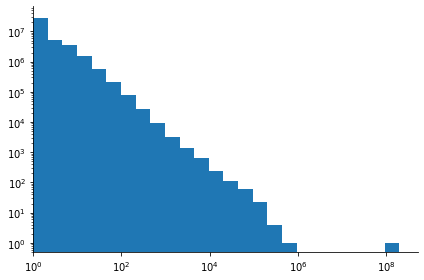

In [26]:
plot_loghist(ds_dumb_address, 25)

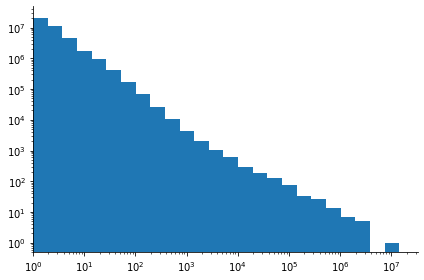

In [27]:
plot_loghist(ds_smart_address[ds_smart_address > 0], 25)

In [28]:
max_x = max(max(ds_dumb_address), max(ds_dumb_tx), max(ds_smart_address), max(ds_smart_tx))

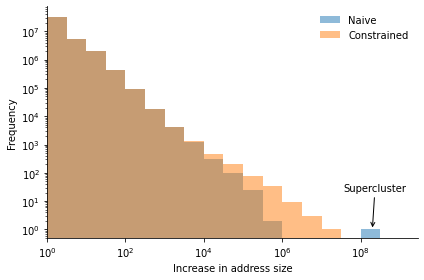

In [29]:
combined_plot_loghist(
    ds_dumb_address[ds_dumb_address > 0],
    ds_smart_address[ds_smart_address > 0],
    max_x=max_x,
    xlabel="Increase in address size",
    filename="cluster-address-increase")

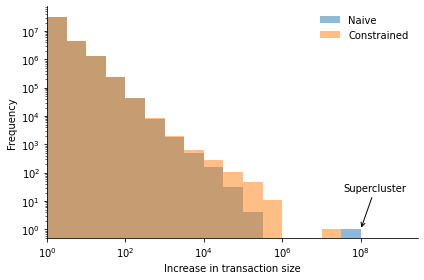

In [30]:
combined_plot_loghist(
    ds_dumb_tx[ds_dumb_tx > 0],
    ds_smart_tx[ds_smart_tx > 0],
    max_x=max_x,
    xlabel="Increase in transaction size",
    filename="cluster-tx-increase")

In [31]:
len(ds_dumb_tx[ds_dumb_tx == 0])

2329436

In [32]:
len(ds_smart_tx[ds_smart_tx == 0])

2522166